<a href="https://colab.research.google.com/github/MORIOMKAMAL/Computer-vision/blob/main/Class_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Compute width and height of new image
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    # Destination points
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Perspective transform
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

In [ ]:
image_path = r"//content//bacterial-leaf-spot.jpg"
orig = cv2.imread(image_path)
hsv = cv2.cvtColor(orig, cv2.COLOR_BGR2HSV)

In [ ]:
blurred = cv2.GaussianBlur(hsv, (5, 5), 0)
mask = cv2.inRange(blurred, (30, 40, 40), (85, 255, 255))  # Green range
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

In [ ]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    print("No green object found.")
    exit()

leaf_contour = max(contours, key=cv2.contourArea)
epsilon = 0.02 * cv2.arcLength(leaf_contour, True)
approx = cv2.approxPolyDP(leaf_contour, epsilon, True)

if len(approx) == 4:
    points = approx.reshape(4, 2)
else:
    rect = cv2.minAreaRect(leaf_contour)
    box = cv2.boxPoints(rect)
    points = box.astype(np.int32)  # Replaces np.int0(box)


In [ ]:
warped = four_point_transform(orig, points)

In [ ]:
warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(warped_gray)

In [ ]:
_, dark_spots = cv2.threshold(clahe_img, 60, 255, cv2.THRESH_BINARY_INV)

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
cleaned = cv2.morphologyEx(dark_spots, cv2.MORPH_OPEN, kernel)

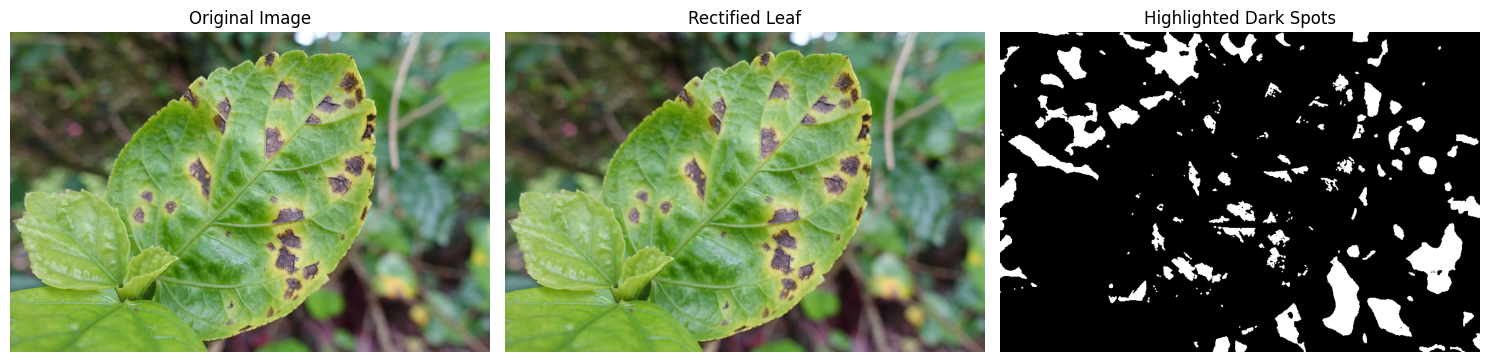

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("Rectified Leaf")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cleaned, cmap='gray')
plt.title("Highlighted Dark Spots")
plt.axis("off")

plt.tight_layout()
plt.show()